# Projekt 4: Generalna ocena jakości modeli przestrzennych RNA

In [1]:
# %pip install pandas biopython joblib scikit-learn catboost

In [2]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from joblib import Parallel, delayed
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

1. Zapoznanie się z udostępnionymi zbiorami danych i ewentualne przetransformowanie ich do postaci ułatwiającej zastosowanie technik sztucznej inteligencji np. integracja danych składowych przechowywanych w różnych formatach z wykorzystaniem jednej spójnej reprezentacji.

In [3]:
DATASET_PATH = Path("./resources/datasets/RNA-Puzzles")

challenges = [f"pz{index:02}" for index in range(1, 11)]

In [4]:
def parse_motifs(challenges: list[str]) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for challenge in challenges:
        current_df = pd.read_csv(
            DATASET_PATH / f"{challenge}/filter-results.txt",
            sep="\t",
            header=None,
            names=[
                "filename",
                "number_of_segments",
                "number_of_residues",
                "nucleotide_ranges",
                "sequences",
            ],
        )
        current_df["challenge_number"] = challenge
        result_df = pd.concat([result_df, current_df])

    result_df = result_df[result_df["number_of_segments"] >= 3]
    return result_df.reset_index(drop=True)


motifs = parse_motifs(challenges)
motifs

,filename,number_of_segments,number_of_residues,nucleotide_ranges,sequences,challenge_number
0,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
1,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
2,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
3,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
4,1_solution_0_rpr_A_8_G,3,24,"A4-A12, B5-B12, B15-B21","CCGCGCCAU, CGCGCCAU, CUGUGGC",pz01
...,...,...,...,...,...,...
673,10_0_solution_4LCK_rpr_B_55_C,3,32,"A48-A63, B16-B21, B50-B59","AGGAUAGUGAAAGCUA, UGGUAG, GGGUUCGAAU",pz10
674,10_0_solution_4LCK_rpr_B_56_G,3,38,"A48-A64, B15-B22, B49-B61","AGGAUAGUGAAAGCUAG, GUGGUAGA, CGGGUUCGAAUCC",pz10
675,10_0_solution_4LCK_rpr_B_57_A,4,42,"A49-A54, A58-A64, B14-B22, B44-B63","GGAUAG, AAGCUAG, AGUGGUAGA, GGUCGCGGGUUCGAAUCCCG",pz10
676,10_0_solution_4LCK_rpr_B_58_A,4,43,"A59-A63, B6-B11, B13-B23, B43-B63","AGCUA, AGUAGU, CAGUGGUAGAA, GGGUCGCGGGUUCGAAUCCCG",pz10


In [5]:
def parse_xml_file(file_path: Path) -> pd.DataFrame:
    tree = ET.parse(file_path)
    root = tree.getroot()
    return pd.DataFrame(
        [
            {
                "filename": child.find("description").find("filename").text,
                "score": child.find("score").text,
            }
            for child in root
        ]
    )


def parse_scores(motifs: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for index, row in motifs.iterrows():
        core_path = DATASET_PATH / f"{row['challenge_number']}"
        xml_path = core_path / f"{row['filename']}-rmsd.xml"

        if xml_path.exists():
            current_df = parse_xml_file(xml_path)
            current_df["solution_directory"] = row["filename"]
            current_df["dataset_files_path"] = core_path / (
                f"{row['filename']}/" + current_df["filename"].apply(lambda x: x[:-4])
            )
            result_df = pd.concat([result_df, current_df])
        else:
            motifs.drop(index, inplace=True)

    return result_df


scores = parse_scores(motifs)
scores

,filename,score,solution_directory,dataset_files_path
0,1_bujnicki_1_rpr.pdb,4.769,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
1,1_bujnicki_2_rpr.pdb,4.594,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
2,1_bujnicki_3_rpr.pdb,3.921,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
3,1_bujnicki_4_rpr.pdb,4.522,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
4,1_bujnicki_5_rpr.pdb,4.616,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
...,...,...,...,...
21,10_DING_5_rpr.pdb,4.516,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
22,10_DING_6_rpr.pdb,3.939,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
23,10_DING_7_rpr.pdb,4.639,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
24,10_DING_8_rpr.pdb,5.66,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...


In [6]:
def parse_pdb_file(file_path: Path) -> pd.DataFrame:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("PDB_structure", f"{file_path}.pdb")

    pdb_data: list = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    pdb_data.append(
                        {
                            "atom_id": atom.serial_number,
                            "atom_name": atom.name,
                            "residue_name": residue.resname,
                            "chain_id": chain.id,
                            "residue_number": residue.id[1],
                            "x": atom.coord[0],
                            "y": atom.coord[1],
                            "z": atom.coord[2],
                            "occupancy": atom.occupancy,
                            "temperature_factor": atom.bfactor,
                        }
                    )
    return pd.DataFrame(pdb_data)


def parse_tor_file(file_path: Path, keep_ids: bool = False) -> pd.DataFrame:
    result_df = pd.read_csv(f"{file_path}.tor", sep="\s+")
    return (
        result_df.drop(columns=["Chain", "ResNum", "Name", "iCode"])
        if not keep_ids
        else result_df.rename(
            columns={
                "Chain": "chain_id",
                "ResNum": "residue_number",
                "Name": "residue_name",
                "iCode": "icode",
            }
        )
    )

2. Krótkie zapoznanie się z dostępnymi przestrzeniami reprezentacji struktur 3D RNA (przestrzenie kartezjańska i kątów torsyjnych) i ich formatami zapisu. Wybór obiecującej przestrzeni na której będziecie Państwo bazować wraz z uzasadnieniem.

In [7]:
example_path = scores["dataset_files_path"].values[0]
example_pdb = parse_pdb_file(example_path)
example_pdb.head()

,atom_id,atom_name,residue_name,chain_id,residue_number,x,y,z,occupancy,temperature_factor
0,1,C1',C,A,1,-20.322001,-0.227,69.922997,1.0,0.0
1,2,C2,C,A,1,-19.306999,-1.206,71.968002,1.0,0.0
2,3,C2',C,A,1,-19.379999,0.818,69.327003,1.0,0.0
3,4,C3',C,A,1,-19.302999,0.409,67.860001,1.0,0.0
4,5,C4,C,A,1,-18.016001,-3.167,71.891998,1.0,0.0


In [8]:
example_tor = parse_tor_file(example_path, keep_ids=True)
example_tor.head()

,chain_id,residue_number,icode,residue_name,alpha,beta,gamma,delta,epsilon,zeta,chi
0,A,1,-,C,-,-176.137,59.054,81.122,-174.56,-80.489,-145.907
1,A,2,-,C,161.855,-159.318,166.249,89.951,-117.771,-80.79,-160.341
2,A,3,-,G,-73.596,158.659,64.143,82.278,-147.484,-77.638,-164.295
3,A,4,-,C,-75.485,171.898,62.668,83.346,-152.214,-73.751,-155.038
4,A,5,-,C,-78.552,172.551,62.180,81.483,-152.556,-73.703,-151.534


3. Określenie procentowych progów pozwalających podzielić dostępny zbiór danych na część treningową, walidacyjną i ewaluacyjną. Czy rozmiar dostępnego zbioru jest wystarczający? Czy należy go rozbudować? Jeśli tak to w jaki sposób?

In [9]:
# train-validation-test splits -> 70-15-15
VALID_TEST_SIZE: float = 0.15
TRAIN_SIZE: float = 1 - (2 * VALID_TEST_SIZE)

assert TRAIN_SIZE > 0 and VALID_TEST_SIZE > 0

4. Określenie sposobu reprezentacji wiedzy, którą dysponujemy (tzn. wektora cech). Czy stosowane będą techniki identyfikacji najistotniejszych cech? Jeśli tak to jakie?

In [10]:
def find_max_tor_lines(scores: pd.DataFrame) -> int:
    return scores["dataset_files_path"].apply(lambda x: len(parse_tor_file(x))).max()


max_tor_lines = find_max_tor_lines(scores)
max_tor_lines

61

In [11]:
REPRESENTATIONS_PATH = Path("./resources/datasets/representations")
TOR_DATASET_PATH = REPRESENTATIONS_PATH / "tor_dataset.csv"

NUMBER_OF_ANGLES = 7
FILL_FEATURES_TO = max_tor_lines * NUMBER_OF_ANGLES  # 61 * 7 = 427


def preprocess_tor_data(tor_data: pd.DataFrame, missing_value: int = 0) -> np.ndarray:
    tor_data = tor_data.replace("-", missing_value).astype(float)
    tor_data = tor_data.values.flatten()
    padding_needed = max(0, FILL_FEATURES_TO - len(tor_data))
    padded_tor_data = np.pad(
        tor_data, pad_width=(0, padding_needed), mode="constant", constant_values=missing_value
    )
    return padded_tor_data


def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    def normalize_column(column: pd.Series) -> pd.Series:
        non_zero_values = column[column != 0]
        min_val = non_zero_values.min()
        max_val = non_zero_values.max()

        column[column != 0] = (
            2 * (non_zero_values - min_val) / (max_val - min_val) - 1 if max_val != min_val else 0
        )
        return column

    return df.apply(normalize_column, axis="columns")


def prepare_tor_dataset(scores: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for _, row in scores.iterrows():
        tor_data = parse_tor_file(row["dataset_files_path"])
        preprocessed_tor_data = preprocess_tor_data(tor_data)

        current_df = pd.DataFrame(preprocessed_tor_data).T
        current_df["score"] = row["score"]
        result_df = pd.concat([result_df, current_df])

    score_copy = result_df["score"].copy()
    result_df = normalize_data(result_df.drop(columns=["score"]))
    result_df["score"] = score_copy
    return result_df


def parallel_processing(scores: pd.DataFrame) -> pd.DataFrame:
    cores = max(1, os.cpu_count() - 1)
    data_splits = np.array_split(scores, cores)
    fn = delayed(prepare_tor_dataset)
    results = Parallel(n_jobs=cores, verbose=10)(fn(data_split) for data_split in data_splits)
    return pd.concat(results)


def make_tor_dataset_csv(scores: pd.DataFrame) -> None:
    dataset = parallel_processing(scores)
    dataset.to_csv(TOR_DATASET_PATH, index=False)


if not TOR_DATASET_PATH.exists():
    make_tor_dataset_csv(scores)

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:   33.1s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   33.4s remaining:  1.4min
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:   34.3s remaining:   45.7s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:   34.4s remaining:   25.8s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:   34.8s remaining:   13.9s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   34.9s finished


In [12]:
tor_dataset = pd.read_csv(TOR_DATASET_PATH)
tor_dataset

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,score
0,0.0,-0.978661,0.339637,0.463333,-0.969821,-0.442532,-0.809215,0.915860,-0.884387,0.940489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.769
1,0.0,0.925007,0.302262,0.458506,-0.919853,-0.430515,-0.901528,-0.367817,0.971242,0.248807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.594
2,0.0,0.969942,0.310983,0.444815,-0.804548,-0.577312,-0.902394,0.905048,-0.871336,0.939470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.921
3,0.0,-0.907328,0.252716,0.409614,0.987071,-0.394564,-0.753726,-0.340666,0.941621,0.283139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.522
4,0.0,0.960478,0.304328,0.482642,-0.788699,-0.441201,-0.924806,-0.395413,1.000000,0.318126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20951,0.0,0.921765,0.350060,0.465399,-0.833842,-0.343431,-0.887391,-0.499000,0.832146,0.583481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.516
20952,0.0,0.933915,0.485690,0.427908,-0.831433,-0.394316,-0.926236,-0.485149,0.825322,0.675647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.939
20953,0.0,0.904442,0.422146,0.510393,-0.825556,-0.387512,-0.887714,-0.412740,0.901270,0.289614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.639
20954,0.0,0.920129,0.353021,0.379568,-0.880728,-0.366675,-0.906016,-0.484275,0.908835,0.714776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.660


In [13]:
def preprocess_tor_dataset(dataset: pd.DataFrame) -> tuple[np.array, np.array]:
    X = dataset.drop(dataset.columns[-1], axis=1)
    y = dataset[dataset.columns[-1]]
    return np.array(X), np.array(y)


X, y = preprocess_tor_dataset(tor_dataset)
X.shape, y.shape

((20956, 427), (20956,))

In [14]:
RANDOM_STATE: int = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE
)

print(
    f"""
    Train size: {X_train.shape} [{X_train.shape[0] / X.shape[0] * 100:.2f}%]
    Valid size: {X_valid.shape} [{X_valid.shape[0] / X.shape[0] * 100:.2f}%]
    Test  size: {X_test.shape} [{X_test.shape[0] / X.shape[0] * 100:.2f}%]
    """
)


    Train size: (14669, 427) [70.00%]
    Valid size: (3143, 427) [15.00%]
    Test  size: (3144, 427) [15.00%]
    


5. Wybór obiecujących technik uczenia maszynowego, które uważacie Państwo, że powinny się sprawdzić podczas rozwiązywania postawionego problemu wraz z uzasadnieniem (np. głębokie sieci neuronowe, SVM, RandomForest ,itd.).

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor

common_params = {"verbose": True, "random_state": RANDOM_STATE}

regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=100, n_jobs=-1, criterion="squared_error", **common_params),
    "MLP": MLPRegressor(validation_fraction=VALID_TEST_SIZE, **common_params),
    "SGD": SGDRegressor(validation_fraction=VALID_TEST_SIZE, **common_params),
    
}

6. Iteracyjne przeprowadzenie procesu uczenia, określenie wartości parametrów kluczowych dla tego procesu (np. zastosowana funkcja straty, learning rate, optimizer, itd.) i wskazanie czy natrafiliście Państwo na jakieś problemy podczas tego procesu np. przeuczenie i jak Państwo sobie z tymi problemami poradziliście o ile rzeczywiście wystąpiły?

7. Optymalizacja wartości hiperparametrów – czy warto je optymalizować w przypadku rozpatrywanego problemu? Jeśli tak to w jaki sposób?

8. Wybór i uzasadnienie zastosowanych miar oceny, przeprowadzenie procesu ewaluacji uzyskanego(ych) modelu(i), podsumowanie i analiza uzyskanych wyników.

In [87]:

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

def make_prediction(Regressor, param_grid: Optional[dict] = None):
    regr = (
        GridSearchCV(Regressor,
                     param_grid,
                     scoring=rmse_scorer,
                     n_jobs=-1,
                     verbose=1,
                     cv=3,
                     return_train_score=True)
        if param_grid
        else Regressor
    )

    regr.fit(X_train, y_train)
    if param_grid:
        print(f"Best params: {regr.best_params_}")

    # y_pred = regr.predict(X_test)
    # return {
    #     "model": regr,
    #     "model_name": type(Regressor).__name__,
    #     "Best params": regr.best_params_,
    #     # "Best score": regr.best_score_,
    #     "predictions": y_pred,
    #     "RMSE": root_mean_squared_error(y_test, y_pred)
    # }

    y_pred = regr.predict(X_test)
    print(f"{type(Regressor).__name__} RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    return regr

In [145]:
grid = {
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, 30],
    },
    "MLP": {
        "hidden_layer_sizes": [(100,), (200,), (200, 100), (300, 200, 100)],
        "alpha": [0.0001, 0.001, 0.01],
        "max_iter": [50],
    },
    "SGD": {
        "alpha": [0.0001, 0.001, 0.01],
        "penalty": ["l2"],
        "learning_rate": ["adaptive"],
        "max_iter": [50, 100, 200, 300, 400],
    },

}

regr = make_prediction(regressors["MLP"], grid["MLP"])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Iteration 1, loss = 31.59656264
Iteration 1, loss = 32.02663177
Iteration 1, loss = 32.42123743
Iteration 2, loss = 23.65377320
Iteration 2, loss = 24.02253413
Iteration 2, loss = 24.31775906
Iteration 1, loss = 28.86012865
Iteration 3, loss = 22.97036279
Iteration 3, loss = 23.73570489
Iteration 3, loss = 23.41616917
Iteration 1, loss = 27.88894775
Iteration 4, loss = 22.45401915
Iteration 4, loss = 23.21035675
Iteration 1, loss = 28.10424073
Iteration 1, loss = 29.21048630
Iteration 1, loss = 28.55117099
Iteration 4, loss = 22.98150336
Iteration 2, loss = 23.67124371
Iteration 5, loss = 22.78247114
Iteration 5, loss = 22.03641692
Iteration 6, loss = 22.46481744
Iteration 2, loss = 22.45938753
Iteration 5, loss = 22.55694590
Iteration 2, loss = 23.86688340
Iteration 2, loss = 23.12034928
Iteration 7, loss = 22.08514213
Iteration 6, loss = 21.55137297
Iteration 2, loss = 22.81332491
Iteration 3, loss = 22.95229987
Iteration 8

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46, loss = 10.86761018
Iteration 22, loss = 13.33046770
Iteration 48, loss = 10.35706332
Iteration 22, loss = 4.59632276
Iteration 24, loss = 12.77042807
Iteration 47, loss = 10.53902643
Iteration 21, loss = 13.33377524
Iteration 48, loss = 10.36134099
Iteration 20, loss = 5.62398881
Iteration 49, loss = 10.22346103
Iteration 23, loss = 12.99954287
Iteration 1, loss = 29.03151359
Iteration 49, loss = 10.17986744
Iteration 22, loss = 12.91260361
Iteration 50, loss = 10.00370199
Iteration 23, loss = 4.84743595


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 25, loss = 12.45084360
Iteration 50, loss = 9.97694735
Iteration 24, loss = 12.47361110


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 23.20297721
Iteration 21, loss = 5.14075092
Iteration 25, loss = 12.08679664
Iteration 23, loss = 12.39308424
Iteration 26, loss = 11.90501219
Iteration 3, loss = 21.90793318
Iteration 24, loss = 4.21870811
Iteration 26, loss = 11.66575407
Iteration 24, loss = 11.91265127
Iteration 22, loss = 4.71789345
Iteration 27, loss = 11.53388843
Iteration 4, loss = 20.61393017
Iteration 1, loss = 27.37642312
Iteration 27, loss = 11.27285063
Iteration 1, loss = 28.36094839
Iteration 25, loss = 11.49164761
Iteration 25, loss = 4.05353788
Iteration 5, loss = 19.41442145
Iteration 28, loss = 10.90229408
Iteration 28, loss = 11.15203230
Iteration 23, loss = 4.67585972
Iteration 26, loss = 11.18733235
Iteration 29, loss = 10.53397783
Iteration 29, loss = 10.78603350
Iteration 6, loss = 18.07596739
Iteration 2, loss = 21.82420927
Iteration 26, loss = 3.76190014
Iteration 24, loss = 4.33424166
Iteration 30, loss = 10.30932824
Iteration 2, loss = 22.83464880
Iteration 27, loss = 10.68

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 50, loss = 5.83629626
Iteration 11, loss = 7.32476039
Iteration 48, loss = 5.72478523
Iteration 12, loss = 6.92237623
Iteration 24, loss = 4.73362570
Iteration 49, loss = 6.14220673
Iteration 43, loss = 2.06931382
Iteration 42, loss = 2.15779010
Iteration 49, loss = 5.48645217
Iteration 25, loss = 4.52556760
Iteration 50, loss = 6.05392433


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 50, loss = 5.34831338
Iteration 12, loss = 6.70949113
Iteration 43, loss = 2.07494168
Iteration 44, loss = 2.01185701
Iteration 26, loss = 4.26249329


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 5.71425240
Iteration 1, loss = 31.59702671
Iteration 1, loss = 32.02719669
Iteration 27, loss = 4.20729518
Iteration 44, loss = 2.06782299
Iteration 2, loss = 23.65422624
Iteration 2, loss = 24.02302491
Iteration 1, loss = 28.24079666
Iteration 45, loss = 2.07894021
Iteration 3, loss = 22.97059660
Iteration 3, loss = 23.41664319
Iteration 28, loss = 3.91724170
Iteration 4, loss = 22.45433639
Iteration 4, loss = 22.98199203
Iteration 45, loss = 2.01121214
Iteration 13, loss = 5.99635718
Iteration 5, loss = 22.03358689
Iteration 5, loss = 22.55586359
Iteration 6, loss = 21.53286708
Iteration 46, loss = 1.93102651
Iteration 29, loss = 3.84216242
Iteration 6, loss = 22.15485418
Iteration 14, loss = 5.22589306
Iteration 7, loss = 21.10093074
Iteration 7, loss = 21.86324720
Iteration 2, loss = 22.61665270
Iteration 8, loss = 20.69529401Iteration 46, loss = 1.93967705

Iteration 8, loss = 21.44269872
Iteration 47, loss = 2.01494029
Iteration 30, loss = 3.79463873
Iteratio

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17, loss = 18.48634681
Iteration 18, loss = 17.75981107
Iteration 34, loss = 3.14950241
Iteration 17, loss = 4.58216999
Iteration 18, loss = 18.17000059
Iteration 19, loss = 17.49805746
Iteration 20, loss = 17.25051782
Iteration 16, loss = 4.85240234
Iteration 1, loss = 32.42157131
Iteration 19, loss = 17.79007107
Iteration 35, loss = 3.05838859
Iteration 50, loss = 2.00509258
Iteration 2, loss = 24.31809349
Iteration 21, loss = 16.91115028
Iteration 20, loss = 17.57950285


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 23.73725098
Iteration 22, loss = 16.66320283
Iteration 36, loss = 2.93104893
Iteration 5, loss = 16.91504285
Iteration 21, loss = 17.24724560
Iteration 23, loss = 16.29362354
Iteration 4, loss = 23.21197051
Iteration 24, loss = 15.98189034
Iteration 22, loss = 16.91637334
Iteration 37, loss = 2.85557226
Iteration 5, loss = 22.78378197
Iteration 18, loss = 4.04142808
Iteration 17, loss = 3.94004489
Iteration 1, loss = 28.86102219
Iteration 25, loss = 15.65758797
Iteration 6, loss = 22.46424566
Iteration 23, loss = 16.66591498
Iteration 26, loss = 15.31430104
Iteration 38, loss = 2.89642258
Iteration 6, loss = 14.65333307
Iteration 7, loss = 22.07435000
Iteration 2, loss = 23.67212406
Iteration 27, loss = 15.04555506
Iteration 24, loss = 16.36010371
Iteration 28, loss = 14.74115972
Iteration 8, loss = 21.72100519
Iteration 25, loss = 16.02715763
Iteration 3, loss = 22.95270014
Iteration 39, loss = 2.80877585
Iteration 29, loss = 14.46647905
Iteration 18, loss = 3.9085

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 23, loss = 3.34930441
Iteration 14, loss = 17.16493313
Iteration 28, loss = 15.20486872
Iteration 44, loss = 11.10493103
Iteration 15, loss = 16.78082589
Iteration 29, loss = 14.93038398
Iteration 49, loss = 2.42957734
Iteration 24, loss = 2.85009285
Iteration 45, loss = 10.93596434
Iteration 1, loss = 28.55165475
Iteration 12, loss = 7.20136374
Iteration 30, loss = 14.58009120
Iteration 16, loss = 16.22419607
Iteration 46, loss = 10.80130829
Iteration 24, loss = 3.25709269
Iteration 2, loss = 23.12138499
Iteration 31, loss = 14.32058707
Iteration 50, loss = 2.35072700


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 47, loss = 10.50454926
Iteration 17, loss = 15.69231966
Iteration 32, loss = 14.03255842
Iteration 3, loss = 22.40907614
Iteration 48, loss = 10.30047450
Iteration 33, loss = 13.71073299
Iteration 18, loss = 15.13794925
Iteration 49, loss = 10.17033946
Iteration 4, loss = 21.82415455
Iteration 1, loss = 29.21091397
Iteration 25, loss = 3.10914655
Iteration 34, loss = 13.55771657
Iteration 25, loss = 2.64002841
Iteration 19, loss = 14.68922819
Iteration 50, loss = 9.93398200
Iteration 5, loss = 21.37297165
Iteration 13, loss = 6.61355605


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 23.86804982
Iteration 35, loss = 13.20843455
Iteration 20, loss = 14.22487833
Iteration 6, loss = 20.81157206
Iteration 36, loss = 12.93858531
Iteration 3, loss = 23.18985771
Iteration 21, loss = 13.77804707
Iteration 26, loss = 2.40515788
Iteration 7, loss = 20.34732756
Iteration 37, loss = 12.71325212
Iteration 1, loss = 28.10526464
Iteration 22, loss = 13.27722106
Iteration 4, loss = 22.63472200
Iteration 26, loss = 2.99603685
Iteration 8, loss = 20.01001584Iteration 38, loss = 12.52050496

Iteration 14, loss = 5.98789112
Iteration 23, loss = 12.96996893
Iteration 27, loss = 2.32620999
Iteration 39, loss = 12.17288519
Iteration 2, loss = 22.82128824
Iteration 24, loss = 12.41405917
Iteration 9, loss = 19.40767450
Iteration 5, loss = 22.05695101
Iteration 40, loss = 11.97987147
Iteration 25, loss = 12.01715935
Iteration 41, loss = 11.74227306
Iteration 27, loss = 2.43736897Iteration 10, loss = 19.03496841

Iteration 3, loss = 21.53651353
Iteration 6, loss = 21.509

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 32, loss = 9.56646872
Iteration 16, loss = 15.99439731
Iteration 29, loss = 2.34609414
Iteration 31, loss = 1.94385966
Iteration 12, loss = 18.50964352
Iteration 8, loss = 14.78548844
Iteration 33, loss = 9.34443948
Iteration 17, loss = 15.37528563
Iteration 1, loss = 27.88971105
Iteration 13, loss = 18.03345873
Iteration 9, loss = 13.69012819
Iteration 18, loss = 14.93929392
Iteration 34, loss = 9.00254032
Iteration 32, loss = 1.86650036
Iteration 2, loss = 22.45946756
Iteration 14, loss = 17.54261625
Iteration 18, loss = 4.77355365
Iteration 35, loss = 8.83697381
Iteration 30, loss = 2.48282160
Iteration 19, loss = 14.46065444
Iteration 10, loss = 12.24143808
Iteration 15, loss = 17.11460656
Iteration 3, loss = 21.18436555
Iteration 36, loss = 8.56832432
Iteration 20, loss = 13.84042803
Iteration 16, loss = 16.49542023
Iteration 33, loss = 1.96677407
Iteration 19, loss = 4.06702314
Iteration 11, loss = 11.26811651
Iteration 37, loss = 8.33099116
Iteration 4, loss = 19.85397

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 31, loss = 10.19011544
Iteration 36, loss = 1.87225107
Iteration 22, loss = 4.73982760
Iteration 35, loss = 8.13990076
Iteration 15, loss = 7.72678071
Iteration 32, loss = 9.80525167
Iteration 39, loss = 1.62175503
Iteration 23, loss = 4.81669092
Iteration 1, loss = 29.03367902
Iteration 33, loss = 9.48938643
Iteration 26, loss = 2.87125452
Iteration 16, loss = 7.35730906
Iteration 36, loss = 7.94082015
Iteration 24, loss = 4.35203425
Iteration 40, loss = 1.55604718
Iteration 34, loss = 9.35044037
Iteration 2, loss = 23.20459293
Iteration 17, loss = 6.67212039
Iteration 37, loss = 7.62742342
Iteration 37, loss = 1.96960664
Iteration 25, loss = 4.19948299
Iteration 35, loss = 8.97768573
Iteration 3, loss = 21.92951155
Iteration 18, loss = 6.12267856
Iteration 27, loss = 2.99294819
Iteration 38, loss = 7.40412814
Iteration 26, loss = 3.98855463
Iteration 36, loss = 8.68446316
Iteration 4, loss = 20.64647323
Iteration 19, loss = 5.89428565
Iteration 41, loss = 1.60850549
Iterati

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 32, loss = 2.65594281
Iteration 29, loss = 3.50251316
Iteration 34, loss = 2.72213774
Iteration 47, loss = 6.51100449
Iteration 30, loss = 3.15966046
Iteration 14, loss = 9.54988283
Iteration 46, loss = 1.60197997
Iteration 35, loss = 2.63281577
Iteration 33, loss = 2.34380705
Iteration 48, loss = 6.29109568
Iteration 1, loss = 28.36387539
Iteration 31, loss = 2.96313914
Iteration 15, loss = 8.45849201
Iteration 43, loss = 1.77097939
Iteration 32, loss = 2.93391226
Iteration 49, loss = 6.17709919
Iteration 36, loss = 2.67491410
Iteration 16, loss = 7.87641710
Iteration 33, loss = 3.03259486
Iteration 50, loss = 6.05413193
Iteration 34, loss = 2.76428678


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 47, loss = 1.48073870
Iteration 34, loss = 2.67443810
Iteration 2, loss = 22.83448341
Iteration 37, loss = 2.62972731
Iteration 17, loss = 7.36163938
Iteration 35, loss = 2.68464088
Iteration 44, loss = 1.64667251
Iteration 1, loss = 27.37691325
Iteration 36, loss = 2.82798990
Iteration 38, loss = 2.42905253
Iteration 35, loss = 2.35262322
Iteration 18, loss = 7.03733607
Iteration 3, loss = 21.33384974
Iteration 37, loss = 2.56638409
Iteration 39, loss = 2.34915975
Iteration 48, loss = 1.63884749
Iteration 19, loss = 6.41278826
Iteration 2, loss = 21.82436271
Iteration 45, loss = 1.94850059
Iteration 40, loss = 2.26268722
Iteration 4, loss = 19.16204899
Iteration 38, loss = 2.31676780
Iteration 36, loss = 2.31968269
Iteration 20, loss = 5.97870653
Iteration 41, loss = 2.42546991
Iteration 39, loss = 2.38386424
Iteration 3, loss = 19.94730959
Iteration 49, loss = 1.38260028
Iteration 5, loss = 17.02314026
Iteration 46, loss = 1.98823663
Iteration 21, loss = 5.69734545
Iteratio

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 50, loss = 1.36518269
Iteration 41, loss = 2.33936424
Iteration 47, loss = 1.70873705
Iteration 6, loss = 14.80923474
Iteration 44, loss = 2.09251636
Iteration 5, loss = 15.59504521
Iteration 23, loss = 4.99674095
Iteration 38, loss = 2.18565793
Iteration 42, loss = 2.25901513
Iteration 45, loss = 2.26911306
Iteration 48, loss = 1.93047770
Iteration 24, loss = 4.71796255
Iteration 43, loss = 2.06672164
Iteration 6, loss = 13.74013965
Iteration 7, loss = 12.73826362
Iteration 1, loss = 28.23908874
Iteration 46, loss = 1.98892481
Iteration 44, loss = 2.03665986
Iteration 39, loss = 2.17331014
Iteration 25, loss = 4.54754883
Iteration 49, loss = 1.77408847
Iteration 47, loss = 2.04319564
Iteration 45, loss = 2.02968445
Iteration 7, loss = 12.14280838
Iteration 26, loss = 4.23656109
Iteration 46, loss = 1.96191527
Iteration 8, loss = 10.91058966
Iteration 48, loss = 2.00870195
Iteration 2, loss = 22.60681281
Iteration 40, loss = 2.37565549
Iteration 8, loss = 10.50404203
Iteratio

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 47, loss = 2.13931808
Iteration 49, loss = 1.95075354
Iteration 28, loss = 3.85273125
Iteration 1, loss = 32.03124225
Iteration 3, loss = 20.68890607
Iteration 50, loss = 1.95515623


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 48, loss = 2.18467195
Iteration 9, loss = 9.08390974
Iteration 9, loss = 10.05255800
Iteration 2, loss = 24.02670052
Iteration 41, loss = 2.15741666
Iteration 29, loss = 3.70678196
Iteration 1, loss = 31.60087057
Iteration 3, loss = 23.42125723
Iteration 49, loss = 1.96080912
Iteration 2, loss = 23.65805062
Iteration 4, loss = 18.73274633
Iteration 4, loss = 22.98652976
Iteration 3, loss = 22.97396071
Iteration 10, loss = 7.75870922
Iteration 30, loss = 3.66288023
Iteration 50, loss = 1.97542201
Iteration 5, loss = 22.55991818


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 42, loss = 2.16688050
Iteration 4, loss = 22.45729834
Iteration 10, loss = 8.46697241
Iteration 6, loss = 22.15677841
Iteration 1, loss = 32.42511186
Iteration 5, loss = 22.03977015
Iteration 7, loss = 21.86376614
Iteration 2, loss = 24.32159683
Iteration 5, loss = 16.93337372
Iteration 31, loss = 3.51016369
Iteration 3, loss = 23.74064351
Iteration 8, loss = 21.42345068
Iteration 6, loss = 21.54697143
Iteration 4, loss = 23.21459473
Iteration 9, loss = 21.00523773
Iteration 7, loss = 21.11568620
Iteration 5, loss = 22.78641113
Iteration 11, loss = 7.10766083
Iteration 10, loss = 20.64647020
Iteration 6, loss = 22.46134717
Iteration 8, loss = 20.72028033
Iteration 43, loss = 2.17781771
Iteration 11, loss = 20.40414527
Iteration 32, loss = 3.32786251
Iteration 7, loss = 22.08612164
Iteration 11, loss = 7.39917334
Iteration 6, loss = 14.73737936
Iteration 12, loss = 19.93254101
Iteration 9, loss = 20.33712423
Iteration 8, loss = 21.73041028
Iteration 13, loss = 19.59758236
Iter

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 42, loss = 11.50335661
Iteration 46, loss = 2.41933061
Iteration 34, loss = 13.55089692
Iteration 38, loss = 11.84443720
Iteration 43, loss = 11.38335264
Iteration 39, loss = 11.60114431
Iteration 35, loss = 13.21618205
Iteration 40, loss = 11.32706379
Iteration 44, loss = 11.07508264
Iteration 36, loss = 12.94307399
Iteration 20, loss = 3.40095582
Iteration 41, loss = 11.06733019
Iteration 47, loss = 2.56337761
Iteration 1, loss = 28.86721483
Iteration 13, loss = 6.61175861
Iteration 45, loss = 10.93388391
Iteration 37, loss = 12.72825847
Iteration 42, loss = 10.81702368
Iteration 19, loss = 3.40975407
Iteration 38, loss = 12.53412720
Iteration 46, loss = 10.81748397
Iteration 43, loss = 10.81157111
Iteration 48, loss = 2.45369389
Iteration 2, loss = 23.67823309
Iteration 39, loss = 12.20808097
Iteration 44, loss = 10.36812706
Iteration 47, loss = 10.47062548
Iteration 40, loss = 12.03939142
Iteration 21, loss = 3.20366170
Iteration 49, loss = 2.40100165
Iteration 45, loss =

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 43, loss = 11.35000737
Iteration 48, loss = 9.55183805
Iteration 22, loss = 3.08639835
Iteration 4, loss = 22.39038637
Iteration 49, loss = 9.34039705
Iteration 44, loss = 11.18965146
Iteration 1, loss = 29.21712104
Iteration 1, loss = 28.55787204
Iteration 50, loss = 9.18949943
Iteration 45, loss = 10.90930154


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 21.85196418
Iteration 15, loss = 5.23988412
Iteration 2, loss = 23.87424648
Iteration 46, loss = 10.71415308
Iteration 21, loss = 2.94793215
Iteration 1, loss = 28.11502113
Iteration 2, loss = 23.12770053
Iteration 47, loss = 10.69748103
Iteration 3, loss = 23.19619241
Iteration 23, loss = 3.23841003
Iteration 6, loss = 21.30154556
Iteration 48, loss = 10.34514812
Iteration 4, loss = 22.64193177
Iteration 2, loss = 22.82272407
Iteration 3, loss = 22.41547316
Iteration 49, loss = 10.20637124
Iteration 50, loss = 9.99068933
Iteration 7, loss = 20.81070447


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 21.52433776
Iteration 4, loss = 21.83022034
Iteration 5, loss = 22.07085744
Iteration 5, loss = 21.37696891
Iteration 4, loss = 20.27967805
Iteration 16, loss = 4.78444120
Iteration 8, loss = 20.29763432
Iteration 22, loss = 2.93679598
Iteration 24, loss = 3.13438323
Iteration 6, loss = 20.81136006
Iteration 1, loss = 27.89977630
Iteration 6, loss = 21.51778630
Iteration 9, loss = 19.76647222
Iteration 5, loss = 18.96206026
Iteration 7, loss = 20.34054471
Iteration 10, loss = 19.24020869
Iteration 7, loss = 20.99101634
Iteration 6, loss = 17.38015145
Iteration 2, loss = 22.46849748
Iteration 17, loss = 4.65431229
Iteration 11, loss = 18.68444471
Iteration 8, loss = 20.00633884
Iteration 8, loss = 20.48889105
Iteration 7, loss = 16.18239363
Iteration 3, loss = 21.19221216
Iteration 23, loss = 2.84087298
Iteration 12, loss = 18.31823517
Iteration 25, loss = 2.74856252
Iteration 9, loss = 19.99996234
Iteration 9, loss = 19.40178174
Iteration 4, loss = 19.85477069
Itera

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 35, loss = 2.67652485
Iteration 48, loss = 6.31563337
Iteration 36, loss = 2.81271071
Iteration 50, loss = 5.47582826
Iteration 38, loss = 2.04039707


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 41, loss = 1.43643913
Iteration 1, loss = 29.04210292
Iteration 33, loss = 2.31163890
Iteration 49, loss = 6.19915103
Iteration 36, loss = 2.74080403
Iteration 37, loss = 2.48681176
Iteration 2, loss = 23.21332461
Iteration 50, loss = 6.07048534


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 37, loss = 2.74074243
Iteration 38, loss = 2.31836068
Iteration 3, loss = 21.95323545
Iteration 34, loss = 2.65575215
Iteration 42, loss = 1.51770240
Iteration 39, loss = 1.93026849
Iteration 1, loss = 28.38068917
Iteration 4, loss = 20.65563363
Iteration 38, loss = 2.38367327
Iteration 39, loss = 2.42456325
Iteration 35, loss = 2.23365436
Iteration 5, loss = 19.46504639
Iteration 1, loss = 27.39358994
Iteration 39, loss = 2.39464500
Iteration 40, loss = 2.40038692
Iteration 43, loss = 1.41063646
Iteration 6, loss = 18.12372734
Iteration 2, loss = 22.84533191
Iteration 40, loss = 2.02042176
Iteration 7, loss = 16.90321312
Iteration 36, loss = 2.41504646
Iteration 40, loss = 2.33519670
Iteration 41, loss = 2.27776342
Iteration 2, loss = 21.84462146
Iteration 3, loss = 21.33324305
Iteration 41, loss = 1.96374121
Iteration 8, loss = 15.44990628
Iteration 42, loss = 2.27648625
Iteration 44, loss = 1.69198752
Iteration 41, loss = 2.46121149
Iteration 43, loss = 2.10500650
Iteratio

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 8.56600034
Iteration 40, loss = 2.43416816
Iteration 6, loss = 13.76862214
Iteration 7, loss = 12.83099410
Iteration 49, loss = 1.99246721
Iteration 45, loss = 1.89532345
Iteration 16, loss = 7.93711932
Iteration 49, loss = 1.34199521
Iteration 41, loss = 2.25716409
Iteration 1, loss = 28.26334394
Iteration 17, loss = 7.44491736
Iteration 50, loss = 1.87395719
Iteration 7, loss = 12.20011356
Iteration 8, loss = 10.92877182


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46, loss = 1.87054239
Iteration 18, loss = 7.08658207
Iteration 50, loss = 1.38634207
Iteration 42, loss = 2.16053612


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 22.63810299
Iteration 19, loss = 6.46703352
Iteration 8, loss = 10.62939258
Iteration 9, loss = 10.29453625
Iteration 47, loss = 1.63256640
Iteration 43, loss = 2.09992572
Iteration 20, loss = 5.96905308
Iteration 3, loss = 20.69616786
Iteration 9, loss = 9.23943014
Iteration 21, loss = 5.75662476
Iteration 48, loss = 1.78853822
Iteration 10, loss = 8.55447114
Iteration 44, loss = 2.02820663
Iteration 22, loss = 5.47977674
Iteration 4, loss = 18.73875371
Iteration 10, loss = 7.67686372
Iteration 49, loss = 1.79374234
Iteration 23, loss = 5.11844883
Iteration 11, loss = 7.44492180
Iteration 45, loss = 2.18864751
Iteration 24, loss = 4.75973227
Iteration 5, loss = 16.96314550
Iteration 11, loss = 7.19698620
Iteration 12, loss = 6.78710121
Iteration 50, loss = 1.65907995
Iteration 25, loss = 4.61178913


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46, loss = 2.20947902
Iteration 26, loss = 4.27912524
Iteration 12, loss = 6.89260149
Iteration 6, loss = 14.70012640
Iteration 13, loss = 5.95326981
Iteration 27, loss = 4.21966458
Iteration 28, loss = 3.97551716
Iteration 13, loss = 5.79092919
Iteration 7, loss = 12.75271152
Iteration 47, loss = 2.09507928
Iteration 29, loss = 3.77249195
Iteration 14, loss = 6.04004885
Iteration 30, loss = 3.84429792
Iteration 8, loss = 11.16405603
Iteration 14, loss = 5.10906558
Iteration 31, loss = 3.54029046
Iteration 15, loss = 5.22871910Iteration 48, loss = 2.28617408

Iteration 32, loss = 3.40573027
Iteration 9, loss = 10.13939091
Iteration 15, loss = 5.30234716
Iteration 33, loss = 3.17841021
Iteration 49, loss = 2.19950906
Iteration 34, loss = 3.20233207
Iteration 16, loss = 4.58057414
Iteration 10, loss = 8.71375217
Iteration 35, loss = 3.14809906
Iteration 16, loss = 4.32983876
Iteration 17, loss = 4.01943768
Iteration 36, loss = 2.95040335
Iteration 50, loss = 2.01654561


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 8.08826806
Iteration 37, loss = 2.84043374
Iteration 17, loss = 4.75780506
Iteration 18, loss = 3.87515382
Iteration 38, loss = 2.78687980
Iteration 12, loss = 7.20002216
Iteration 39, loss = 2.79395923
Iteration 18, loss = 3.93327098
Iteration 19, loss = 3.55239936
Iteration 40, loss = 2.91304727
Iteration 13, loss = 6.75586107
Iteration 41, loss = 2.68523402
Iteration 19, loss = 3.54065110
Iteration 20, loss = 3.40077263
Iteration 42, loss = 2.51087551
Iteration 14, loss = 6.04829249
Iteration 43, loss = 2.73686645
Iteration 20, loss = 3.24928946
Iteration 21, loss = 3.25246089
Iteration 44, loss = 2.78933108
Iteration 15, loss = 5.36866972
Iteration 45, loss = 2.56091861
Iteration 21, loss = 3.03755649
Iteration 22, loss = 3.11830327
Iteration 46, loss = 2.49024977
Iteration 16, loss = 4.89692705
Iteration 47, loss = 2.66820888
Iteration 22, loss = 3.02772561
Iteration 23, loss = 3.14312552
Iteration 48, loss = 2.54132464
Iteration 17, loss = 4.85619775
Iteratio

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 4.95590151
Iteration 24, loss = 2.80576941
Iteration 25, loss = 2.86771618
Iteration 19, loss = 4.12792192
Iteration 26, loss = 2.44964327
Iteration 25, loss = 3.20725920
Iteration 20, loss = 4.19601784
Iteration 27, loss = 2.46903644
Iteration 26, loss = 3.22848218
Iteration 21, loss = 3.77629970
Iteration 28, loss = 2.60847079
Iteration 27, loss = 2.52085651
Iteration 22, loss = 3.81793210
Iteration 29, loss = 2.16292572
Iteration 28, loss = 2.29690854
Iteration 23, loss = 3.55927924
Iteration 30, loss = 1.97630857
Iteration 29, loss = 2.27873973
Iteration 24, loss = 3.38739289
Iteration 31, loss = 1.92453877
Iteration 30, loss = 2.39383554
Iteration 25, loss = 3.18654891
Iteration 32, loss = 1.87660120
Iteration 31, loss = 2.36388407
Iteration 26, loss = 2.92738811
Iteration 33, loss = 2.01406016
Iteration 32, loss = 2.44800924
Iteration 27, loss = 3.03850154
Iteration 34, loss = 1.95443091
Iteration 33, loss = 2.06701279
Iteration 28, loss = 3.00372472
Iteratio

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 49, loss = 1.92662361
Iteration 44, loss = 2.02880240
Iteration 50, loss = 1.69830510
Iteration 45, loss = 2.25736287


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46, loss = 2.13875666
Iteration 47, loss = 2.13420168
Iteration 48, loss = 2.36081829
Iteration 49, loss = 2.37555705
Iteration 50, loss = 2.10837689


/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 27.33570734
Iteration 2, loss = 23.14933424
Iteration 3, loss = 22.34747855
Iteration 4, loss = 21.66018172
Iteration 5, loss = 20.99325598
Iteration 6, loss = 20.36283587
Iteration 7, loss = 19.71321614
Iteration 8, loss = 19.13643059
Iteration 9, loss = 18.51032505
Iteration 10, loss = 17.87686137
Iteration 11, loss = 17.14118853
Iteration 12, loss = 16.52528346
Iteration 13, loss = 15.91810572
Iteration 14, loss = 15.25724330
Iteration 15, loss = 14.75810155
Iteration 16, loss = 14.17013171
Iteration 17, loss = 13.60121310
Iteration 18, loss = 13.16379483
Iteration 19, loss = 12.55850981
Iteration 20, loss = 12.20884695
Iteration 21, loss = 11.72618182
Iteration 22, loss = 11.27027403
Iteration 23, loss = 10.97905291
Iteration 24, loss = 10.57534455
Iteration 25, loss = 10.22441037
Iteration 26, loss = 9.86362735
Iteration 27, loss = 9.52825372
Iteration 28, loss = 9.21209052
Iteration 29, loss = 9.02205077
Iteration 30, loss = 8.68955428
Iteration 31, loss = 8.3

/home/alex/Repos/BIO/2024-siwb/project-4/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [156]:
from sklearn.model_selection import KFold

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# regr = SGDRegressor(validation_fraction=VALID_TEST_SIZE,
#                     alpha=0.001,
#                     penalty="l2",
#                     learning_rate="adaptive",
#                     max_iter=100, 
#                     **common_params)

regr = MLPRegressor(validation_fraction=VALID_TEST_SIZE,
                    alpha=0.01,
                    hidden_layer_sizes=(300, 200, 100),
                    # hidden_layer_sizes=(100, 200, 400, 200, 100),
                    max_iter=50, 
                    **common_params)


kf = KFold(n_splits=50, shuffle=True, random_state=RANDOM_STATE)
train_scores, test_scores = [], []

for train_index, test_index in kf.split(X_train):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    # track the fitting process
    regr.partial_fit(X_train_kf, y_train_kf)

    y_pred = regr.predict(X_test_kf)
    train_scores.append(root_mean_squared_error(y_train_kf, regr.predict(X_train_kf)))
    test_scores.append(root_mean_squared_error(y_test_kf, y_pred))
    print(f"KFold RMSE score: {root_mean_squared_error(y_test_kf, y_pred)}")

Iteration 1, loss = 28.34376068
KFold RMSE score: 7.660562555580378
Iteration 1, loss = 22.12635782
KFold RMSE score: 7.38194107381078
Iteration 1, loss = 19.78395343
KFold RMSE score: 5.909723603081261
Iteration 1, loss = 17.31856574
KFold RMSE score: 5.633061649828924
Iteration 1, loss = 15.63385006
KFold RMSE score: 4.368722419404902
Iteration 1, loss = 13.69521326
KFold RMSE score: 4.159937726892865
Iteration 1, loss = 12.26996973
KFold RMSE score: 5.015932173834847
Iteration 1, loss = 11.22488756
KFold RMSE score: 4.133176511309874
Iteration 1, loss = 10.42288684
KFold RMSE score: 3.6534984775826036
Iteration 1, loss = 9.16467763
KFold RMSE score: 4.500829210784396
Iteration 1, loss = 8.22683293
KFold RMSE score: 4.234300468317096
Iteration 1, loss = 8.06073098
KFold RMSE score: 3.4531159185855542
Iteration 1, loss = 6.98506464
KFold RMSE score: 4.790371893262773
Iteration 1, loss = 6.80890644
KFold RMSE score: 3.536692868019001
Iteration 1, loss = 6.17689240
KFold RMSE score: 3.9

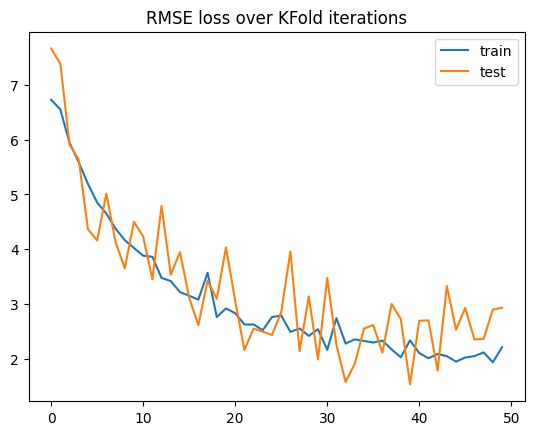

In [157]:
import matplotlib.pyplot as plt

plt.plot(train_scores, label="train")
plt.plot(test_scores, label="test")
plt.title("RMSE loss over KFold iterations")
plt.legend()
plt.show()


In [18]:
mlp_param_grid = {
    "hidden_layer_sizes": [100, 200, 300, 400, 500],
    # "learning_rate": ["constant", "invscaling", "adaptive"],
    "learning_rate_init": [0.001, 0.01, 0.1],
}

make_prediction(regressors["MLP"])

Iteration 1, loss = 29.36487335
Iteration 2, loss = 23.57195062
Iteration 3, loss = 22.87507654
Iteration 4, loss = 22.32791235
Iteration 5, loss = 21.75146987
Iteration 6, loss = 21.27890409
Iteration 7, loss = 20.72309739
Iteration 8, loss = 20.30301966
Iteration 9, loss = 19.88245273
Iteration 10, loss = 19.44968173
Iteration 11, loss = 19.07676484
Iteration 12, loss = 18.65063376
Iteration 13, loss = 18.25403117
Iteration 14, loss = 17.93963304
Iteration 15, loss = 17.54297237
Iteration 16, loss = 17.08117283
Iteration 17, loss = 16.69572689
Iteration 18, loss = 16.35557916
Iteration 19, loss = 15.96447394
Iteration 20, loss = 15.64129571
Iteration 21, loss = 15.24733737
Iteration 22, loss = 14.95423309
Iteration 23, loss = 14.53053232
Iteration 24, loss = 14.26078410
Iteration 25, loss = 14.00630311
Iteration 26, loss = 13.62858118
Iteration 27, loss = 13.39293342
Iteration 28, loss = 13.07327187
Iteration 29, loss = 12.80151778
Iteration 30, loss = 12.52536745
Iteration 31, loss 

'MLPRegressor RMSE score: 7.005053193636907'

In [19]:
def make_catboost_prediction():
    model = CatBoostRegressor()
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True)

    y_pred = model.predict(X_test)
    return f"CatBoost RMSE score: {root_mean_squared_error(y_test, y_pred)}"

In [20]:
make_catboost_prediction()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077628
0:	learn: 7.0843961	test: 7.0611324	best: 7.0611324 (0)	total: 99.3ms	remaining: 1m 39s
1:	learn: 7.0254601	test: 7.0020691	best: 7.0020691 (1)	total: 119ms	remaining: 59.4s
2:	learn: 6.9634545	test: 6.9425982	best: 6.9425982 (2)	total: 134ms	remaining: 44.5s
3:	learn: 6.9068425	test: 6.8893882	best: 6.8893882 (3)	total: 148ms	remaining: 36.9s
4:	learn: 6.8617022	test: 6.8472804	best: 6.8472804 (4)	total: 162ms	remaining: 32.2s
5:	learn: 6.8169119	test: 6.8064550	best: 6.8064550 (5)	total: 176ms	remaining: 29.2s
6:	learn: 6.7787190	test: 6.7707393	best: 6.7707393 (6)	total: 191ms	remaining: 27s
7:	learn: 6.7394399	test: 6.7344611	best: 6.7344611 (7)	total: 205ms	remaining: 25.4s
8:	learn: 6.7047664	test: 6.7027934	best: 6.7027934 (8)	total: 222ms	remaining: 24.4s
9:	learn: 6.6717028	test: 6.6755031	best: 6.6755031 (9)	total: 236ms	remaining: 23.4s
10:	learn: 6.6402414	test: 6.6487030	best: 6.6487030 (10)	total: 250ms	remaining: 22.5s
11:	learn: 6.6113797	t

'CatBoost RMSE score: 4.224652313786899'